### Getting Started

This notebook illustrates how scenes consisting of objects, lights, and cameras can be defined and rendered with the simple renderer. We also solve a small inverse graphics problem at the end.

##### Create a Context for Differentiable Rendering and a Renderer

First import necessary packages and then create a render context for `nvdiffrast`.

In [1]:
import matplotlib.pyplot as plt
import math
import nvdiffrast.torch as dr
import torch
from tqdm import tqdm

from utilities import *

# Select a device (GPU 0) and create a context for nvdiffrast
device         = torch.device('cuda:0')
render_context = dr.RasterizeGLContext(device=device)

Create an instance of the simple renderer, which implements shadow mapping and is built around a custom scene representation.

In [2]:
from diffshadow.simple_renderer import SimpleRenderer

renderer = SimpleRenderer(render_context)

##### Define a Scene 
A scene is composed of 3D objects (represented by triangle meshes), lights and a camera

In [3]:
from diffshadow import create_orthographic_projection_matrix, create_lookat_matrix
from diffshadow.simple_renderer import Mesh, DirectionalLight, Camera, load_mesh, create_plane_mesh, weld_seams

# Load a 3D model as triangle mesh
spot_mesh = weld_seams(Mesh(*load_mesh("data/spot.obj", device=device)))
spot_mesh.vertices[:, 1] += 0.77 # Add some offset to the y-direction to place the mesh on top of the ground plane

# Create the floor plane
floor_mesh = create_plane_mesh(position=[0, 0, 0], normal=[0, 1, 0], size=2, device=device)

# Define a directional light
light = DirectionalLight(direction=torch.tensor([0, 1, 0], dtype=torch.float32, device=device))

# Define an orthographic camera using a projection matrix and view matrix
camera = Camera(
    projection_matrix=create_orthographic_projection_matrix(near=0.1, far=10.0, size=1.0, device=device),
    view_matrix=create_lookat_matrix(eye=[-1.0, 1, -1.0], focus=[0.2, 0.5, 0.2], up=[0.0, 1.0, 0.0]).to(device),
)

c:\Users\mworchel\Documents\work\code\differentiable-shadow-mapping\diffshadow\simple_renderer\mesh_io.py:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  vertex_normals = torch.from_numpy(mesh.vertex_normals).to(device, dtype=torch.float32)


##### Render a Scene 
The function `SimpleRenderer.render` shades the scene with the Lambert diffuse model and uses shadow mapping to compute shadows.

c:\Users\mworchel\Miniconda3\envs\diffshadow_dev\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


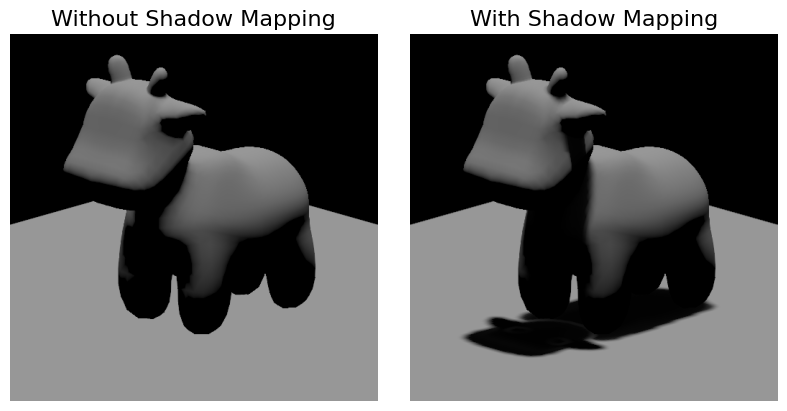

In [4]:
from diffshadow import to_display_image

# Render without shadow
img_no_shadow = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light], camera=camera, resolution=(512, 512), ambient=0, use_shadows=False)

# Render with shadow
img = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light], camera=camera, resolution=(512, 512), ambient=0)

plot(img_no_shadow, img, titles=["Without Shadow Mapping", "With Shadow Mapping"], title_args={'fontsize':16}, axis_off=True, size=4)

The reference implementation supports three types of light sources: directional lights, spot lights, and omnidirectional point lights.

c:\Users\mworchel\Documents\work\code\differentiable-shadow-mapping\diffshadow\shadow.py:99: UserWarning: Omni-directional point light support is preliminary: filtering can generate visible seams.
  warnings.warn("Omni-directional point light support is preliminary: filtering can generate visible seams.")


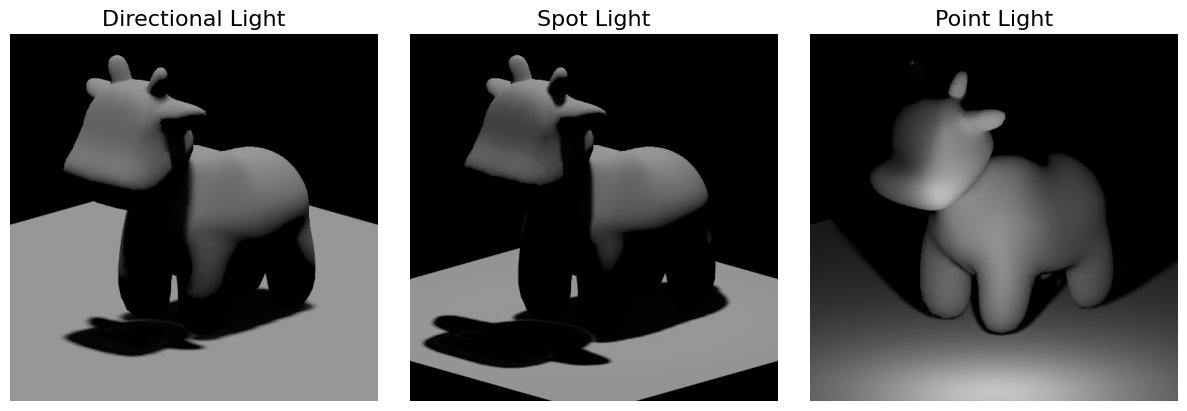

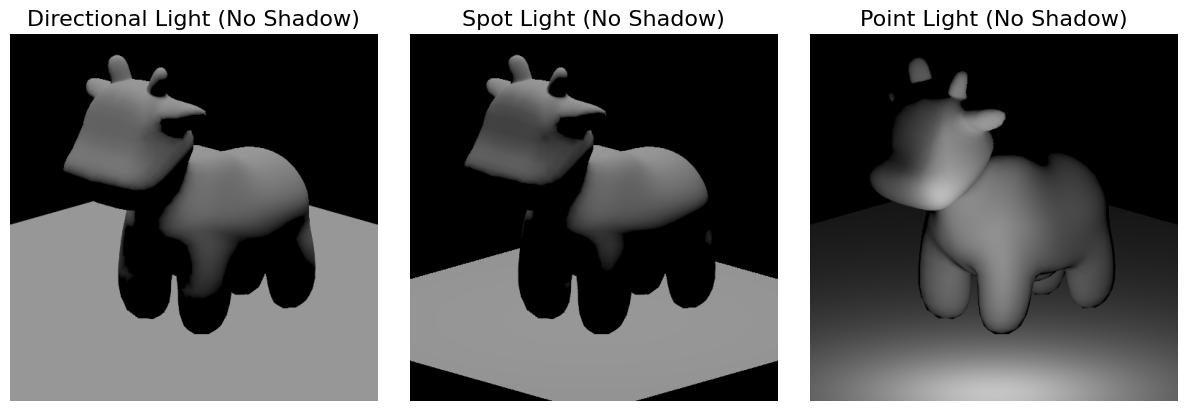

In [5]:
from diffshadow.simple_renderer import SpotLight, PointLight

# Define two additional lights
light_spot = SpotLight(
    view_matrix=create_lookat_matrix(eye=[0, 4, 0], focus=[0, 0, 0], up=[1, 0, 0]).to(device),
    fovy=35,
)

light_point = PointLight(
    position=torch.tensor([-1, 0.75, -1], device=device)
)

# Enable shadow mapping
img_directional = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light],       camera=camera, resolution=(512, 512), ambient=0, use_shadows=True)
img_spot        = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light_spot],  camera=camera, resolution=(512, 512), ambient=0, use_shadows=True)
img_point       = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light_point], camera=camera, resolution=(512, 512), ambient=0, use_shadows=True)

plot(img_directional, img_spot, img_point, titles=["Directional Light", "Spot Light", "Point Light"], title_args={'fontsize':16}, axis_off=True, size=4)

# Disable shadow mapping
img_directional = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light],       camera=camera, resolution=(512, 512), ambient=0, use_shadows=False)
img_spot        = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light_spot],  camera=camera, resolution=(512, 512), ambient=0, use_shadows=False)
img_point       = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light_point], camera=camera, resolution=(512, 512), ambient=0, use_shadows=False)

plot(img_directional, img_spot, img_point, titles=["Directional Light (No Shadow)", "Spot Light (No Shadow)", "Point Light (No Shadow)"], title_args={'fontsize':16}, axis_off=True, size=4)

The shadow mapping algorithm can be configured by changing the shadow map resolution for the light and the smoothing kernel

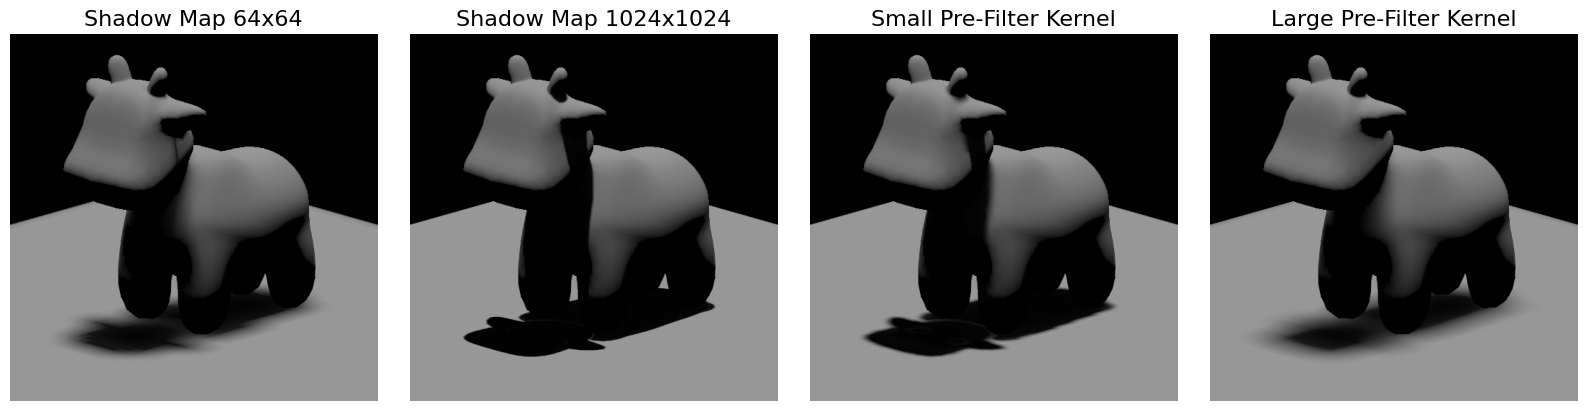

In [6]:
# Define directional lights with low/high shadow map resolution
light_low_shadow_resolution = DirectionalLight(direction=light.direction, resolution=(64, 64))
img_low_resolution = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light_low_shadow_resolution], camera=camera, resolution=(512, 512), ambient=0)

light_high_shadow_resolution = DirectionalLight(direction=light.direction, resolution=(1024, 1024))
img_high_resolution = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light_high_shadow_resolution], camera=camera, resolution=(512, 512), ambient=0)

img_small_filter = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light], camera=camera, resolution=(512, 512), ambient=0, smoothing_kernel_width=3)
img_large_filter = renderer.render(meshes=[spot_mesh, floor_mesh], lights=[light], camera=camera, resolution=(512, 512), ambient=0, smoothing_kernel_width=17)

plot(img_low_resolution, img_high_resolution, img_small_filter, img_large_filter, titles=[
    f"Shadow Map {light_low_shadow_resolution.resolution[0]}x{light_low_shadow_resolution.resolution[1]}",
    f"Shadow Map {light_high_shadow_resolution.resolution[0]}x{light_high_shadow_resolution.resolution[1]}",
    f"Small Pre-Filter Kernel",
    f"Large Pre-Filter Kernel"
], title_args={'fontsize':16}, axis_off=True, size=4)

The scene can be rendered with an arbitrary number of lights

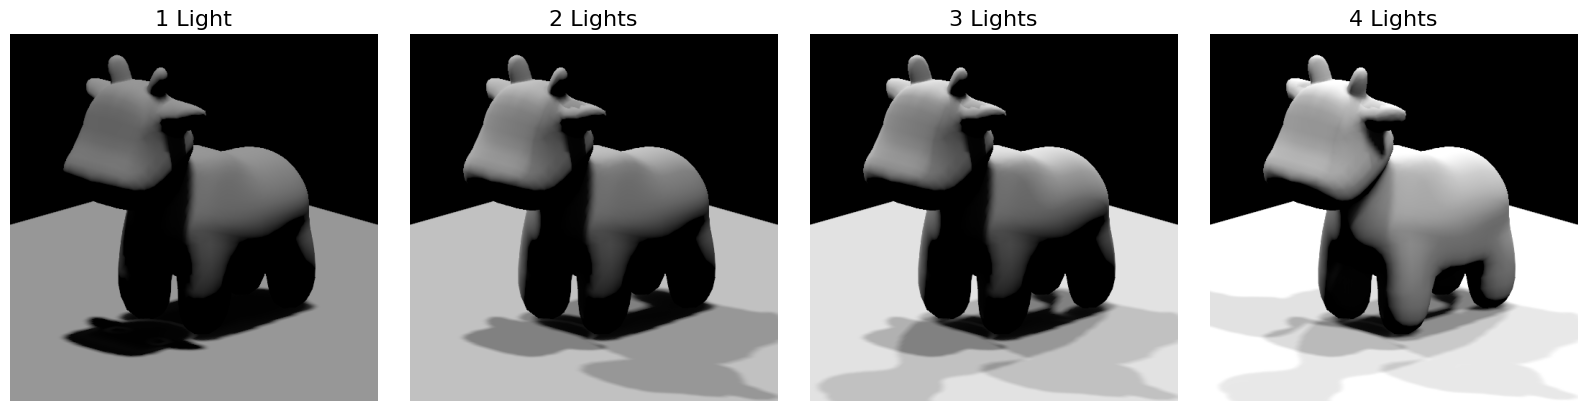

In [7]:
from diffshadow.simple_renderer import azimuth_elevation_to_direction

additional_lights = [
    DirectionalLight(direction=azimuth_elevation_to_direction(azimuth=0, elevation=math.pi/4).to(device)),
    DirectionalLight(direction=azimuth_elevation_to_direction(azimuth=-math.pi/3, elevation=math.pi/4).to(device)),
    DirectionalLight(direction=azimuth_elevation_to_direction(azimuth=math.pi, elevation=math.pi/3).to(device))
]

# Render images with the base light defined at the very top and with i additional lights from the list above
imgs = []
for i in range(len(additional_lights) + 1):
    lights = [light]+additional_lights[0:i]
    img = renderer.render(meshes=[spot_mesh, floor_mesh], lights=lights, camera=camera, resolution=(512, 512), ambient=0)
    imgs += [img]

plot(*imgs, titles=[f"{1+i} Light{'s' if i > 0 else ''}" for i in range(len(imgs))], title_args={'fontsize':16}, axis_off=True, size=4)

##### Optimization with Shadows

The implementation of shadow mapping is differentiable, so the `SimpleRenderer` can be used in a gradient descent-based optimization.

Here, a simplified pose estimation problem is solved: given only an image of the *shadow* cast by an object, recover the object rotation by comparing the reference shadow image to the shadow image synthesized using the current rotation estimate.

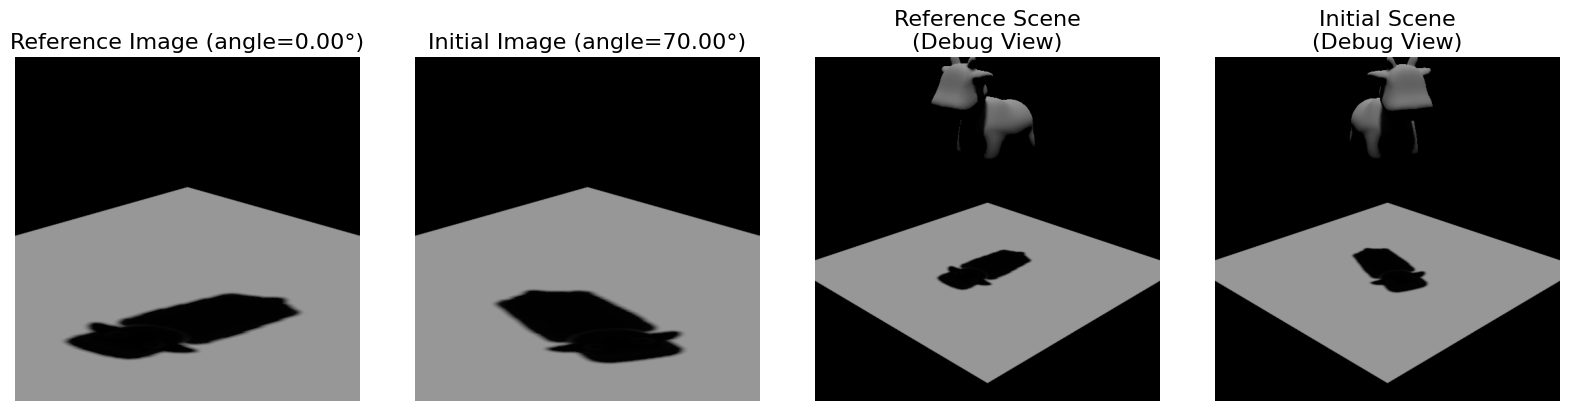

In [8]:
from diffshadow import create_perspective_projection_matrix, create_rotation_matrix, apply_transformation

# Create a debug camera so we can have a look at the scene from a different point of view
camera_debug = Camera(
    projection_matrix=create_perspective_projection_matrix(fovy=30, near=0.1, far=20.0, device=device),
    view_matrix=create_lookat_matrix(eye=[-6.0, 4, -6.0], focus=[0.2, 0.5, 0.2], up=[0.0, 1.0, 0.0]).to(device),
)

# Create a copy of the mesh and lift it high enough so only the shadow is visible
spot_mesh_reference = spot_mesh.with_vertices(spot_mesh.vertices.clone())
spot_mesh_reference.vertices[:, 1] += 1.5

# Define a convenience function to render the reference mesh with a rotation in the x-z-plane applied to vertices
def render_with_angle(angle, custom_camera=None):
    # Create a matrix for a rotation in the xz plane
    R = create_rotation_matrix(angle, i=0, j=2, device=device)

    # Get a mesh with rotated vertices
    vertices = apply_transformation(spot_mesh_reference.vertices, R, mode='euclidean')
    spot_mesh_reference_with_rotation = spot_mesh_reference.with_vertices(vertices)

    # Render the mesh
    img = renderer.render(meshes=[spot_mesh_reference_with_rotation, floor_mesh], lights=[light], camera=camera if custom_camera is None else custom_camera, resolution=(512, 512), ambient=0)

    return img

# Define the reference angle here in degree
angle_ref = math.radians(0)
img_ref       = render_with_angle(angle_ref)
img_ref_debug = render_with_angle(angle_ref, camera_debug)

# Start with an initial angle of 70 degrees
angle_opt = torch.tensor(math.radians(70), dtype=torch.float32, device=device, requires_grad=True)
angle_opt_initial = angle_opt.clone().detach()
img_opt_initial       = render_with_angle(angle_opt_initial)
img_opt_initial_debug = render_with_angle(angle_opt_initial, camera_debug)

plot(img_ref, img_opt_initial, img_ref_debug, img_opt_initial_debug, titles=[
    f"Reference Image (angle={angle_ref:.02f}°)",
    f"Initial Image (angle={math.degrees(float(angle_opt_initial)):.02f}°)",
    f"Reference Scene\n(Debug View)",
    f"Initial Scene\n(Debug View)"
], title_args={'fontsize':16}, axis_off=True, size=4)

100%|██████████| 200/200 [00:01<00:00, 110.86it/s, loss=1.32e-12]


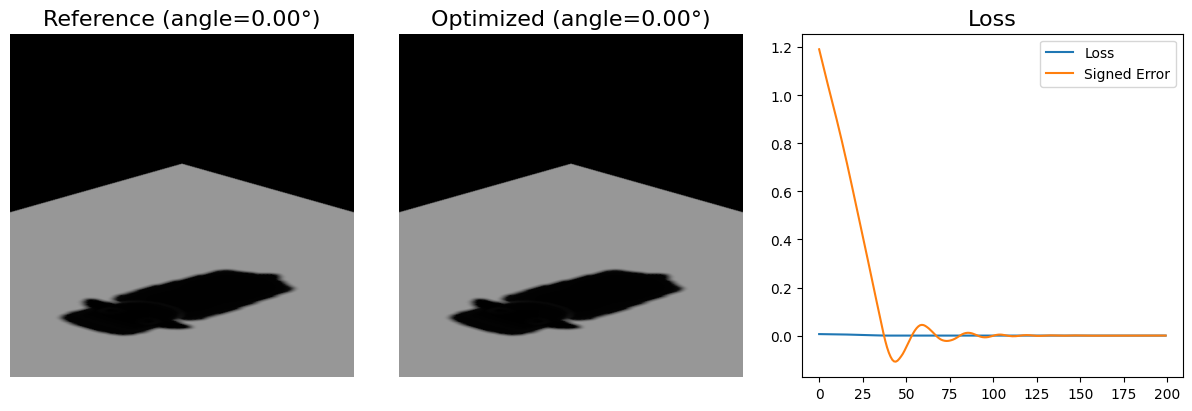

In [9]:
optimizer = torch.optim.Adam([angle_opt], lr=0.03)

losses = []
angles = []
errors = []
progress_bar = tqdm(range(200))
for iteration in progress_bar:
    img_opt = render_with_angle(angle_opt)

    loss = torch.mean((img_ref - img_opt)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    progress_bar.set_postfix({'loss': float(loss.detach().cpu())})

    losses += [float(loss)]
    angles += [float(angle_opt)]
    errors += [float(angle_opt - angle_ref)]

plot(img_ref, img_opt, {"Loss": losses, "Signed Error": errors}, titles=[
    f"Reference (angle={0:.02f}°)",
    f"Optimized (angle={math.degrees(float(angle_opt)):.02f}°)",
    "Loss"
], title_args={'fontsize':16}, axis_off=True, size=4)

In [10]:
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='html5')

# Create a video of the optimization
imgs = []
imgs_debug = []
for angle in angles:
    imgs += [ render_with_angle(angle) ]
    imgs_debug += [ render_with_angle(angle, camera_debug) ]

fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].set_axis_off()
axs[0].set_title("Predicted Image")
axs[1].set_axis_off()
axs[1].set_title("Debug View")
im0 = axs[0].imshow(to_display_image(imgs[0], grayscale_to_rgb=True))
im1 = axs[1].imshow(to_display_image(imgs_debug[0], grayscale_to_rgb=True))

def animate(i):
    im0.set_array(to_display_image(imgs[i], grayscale_to_rgb=True))
    im1.set_array(to_display_image(imgs_debug[i], grayscale_to_rgb=True))
    return [im0, im1]

anim = animation.FuncAnimation(fig, animate, frames=len(imgs), interval=1000/60, blit=False)
plt.close(fig)

HTML(anim.to_html5_video())